In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/szeged-weather/weatherHistory.csv


## *Imports*

In [7]:
#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy 


%matplotlib inline
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

## *Exploração de Dados*

In [37]:
data = pd.read_csv('/kaggle/input/szeged-weather/weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [9]:
data.dtypes

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Loud Cover                  float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

In [10]:
categorical_cols = [cname for cname in data.columns if
                   data[cname].dtype == "object"]
numerical_cols = [cname for cname in data.columns if 
                data[cname].dtype in ['int64', 'float64']]

print ('Categoricas: ', categorical_cols)
print ('Numericas:', numerical_cols)

Categoricas:  ['Formatted Date', 'Summary', 'Precip Type', 'Daily Summary']
Numericas: ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)']


In [11]:
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


Loud Cover vale 0 sempre, portanto removeremos.

In [12]:
data.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

Provavelmente os valores faltantes não foram documentados.

array([[<Axes: title={'center': 'Temperature (C)'}>,
        <Axes: title={'center': 'Apparent Temperature (C)'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'Wind Speed (km/h)'}>,
        <Axes: title={'center': 'Wind Bearing (degrees)'}>,
        <Axes: title={'center': 'Visibility (km)'}>],
       [<Axes: title={'center': 'Loud Cover'}>,
        <Axes: title={'center': 'Pressure (millibars)'}>, <Axes: >]],
      dtype=object)

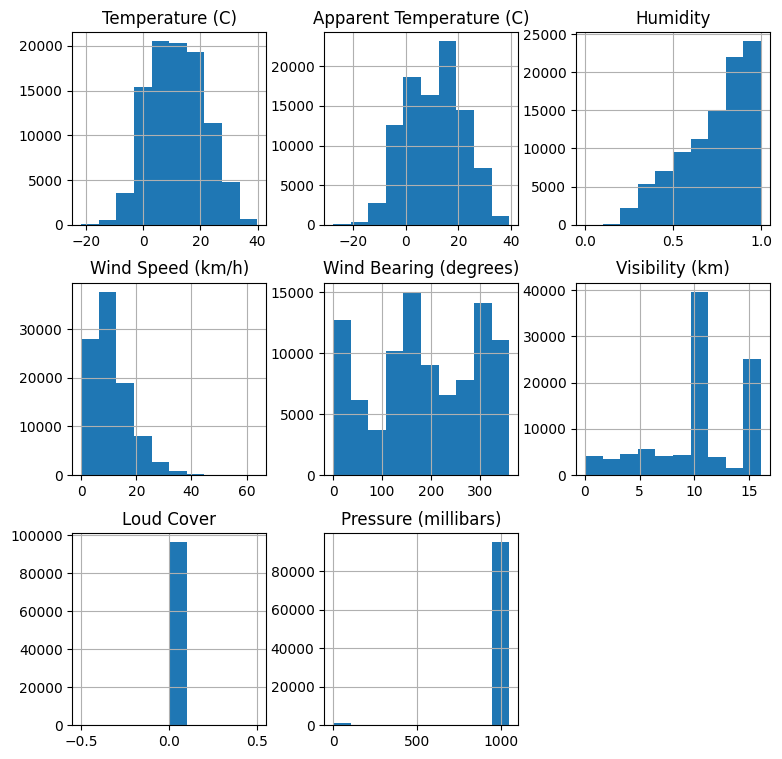

In [13]:
data[numerical_cols].hist(figsize=(9, 9))

In [14]:
# Pressão não pode ser 0 então olharemos um pouco pra essa coluna
data.loc[(data['Pressure (millibars)'] == 0 )]

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
858,2006-08-14 18:00:00.000 +0200,Partly Cloudy,rain,22.477778,22.477778,0.58,10.8192,159.0,11.1251,0.0,0.0,Mostly cloudy until night.
874,2006-08-15 10:00:00.000 +0200,Partly Cloudy,rain,21.061111,21.061111,0.73,7.7924,264.0,11.2056,0.0,0.0,Partly cloudy until evening.
924,2006-08-17 12:00:00.000 +0200,Clear,rain,28.838889,29.611111,0.51,9.6600,177.0,9.9820,0.0,0.0,Partly cloudy until morning.
945,2006-08-18 09:00:00.000 +0200,Clear,rain,24.950000,24.950000,0.69,16.0195,180.0,9.9015,0.0,0.0,Partly cloudy starting overnight continuing un...
1074,2006-08-22 18:00:00.000 +0200,Partly Cloudy,rain,23.811111,23.811111,0.45,16.0195,290.0,11.2056,0.0,0.0,Partly cloudy starting in the morning.
...,...,...,...,...,...,...,...,...,...,...,...,...
93147,2016-03-23 06:00:00.000 +0100,Clear,rain,2.750000,-0.322222,0.82,11.3988,39.0,6.1180,0.0,0.0,Overcast starting in the afternoon.
93149,2016-03-23 08:00:00.000 +0100,Clear,rain,3.838889,1.716667,0.82,8.2593,58.0,6.1180,0.0,0.0,Overcast starting in the afternoon.
93150,2016-03-23 09:00:00.000 +0100,Clear,rain,5.000000,4.005556,0.92,5.2486,84.0,4.9910,0.0,0.0,Overcast starting in the afternoon.
93152,2016-03-23 11:00:00.000 +0100,Clear,rain,5.050000,2.472222,0.92,11.2700,10.0,4.9910,0.0,0.0,Overcast starting in the afternoon.


In [15]:
# Anisando as Features Categoricas
print (categorical_cols) 

['Formatted Date', 'Summary', 'Precip Type', 'Daily Summary']


In [16]:
# Notamos que data não é uma feature categorica por mais que seja um object
categorical_cols.remove('Formatted Date')
# Olhando os valores unicos das colunas, conferindo se não um valor unico que se repete apenas uma vez
# Isso estragaria a divisão de dados, poís, permitira que esse valor estivesse apenas em um dos bancos, train ou test
for cols in categorical_cols:
    print('\n', data[cols].value_counts(dropna=False))



 Summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8


## *Limpando Banco de Dados*

In [17]:
# Removendo a coluna cujos valores são sempre 0
data=data.drop('Loud Cover',axis=1)

In [18]:
# Notamos que Formatted data não é categorica e na verdade uma data
# Portanto vamos formatar essa coluna como data.
data[['Date', 'Fuse']] = (data['Formatted Date'].str.split("+", expand=True))
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Hour'] = data['Date'].dt.hour

In [19]:
# Removendo a colunas antigas do dataframe
dates=['Formatted Date', 'Fuse', 'Date']
data=data.drop(dates, axis=1)

In [20]:
data.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Year,Month,Day,Hour
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,2006,4,1,0
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,2006,4,1,1
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,2006,4,1,2
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,2006,4,1,3
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,2006,4,1,4


In [21]:
# criando um filtro onde remove as linhas com summarys que aparecem apenas 1 vez
summary_counts = data['Summary'].value_counts()
data_filt = data.loc[data['Summary'].map(summary_counts) != 1]

In [22]:
# Redefinindo quem são as colunas categoricas e numericas apos manipular o dataframe
categorical_cols = [cname for cname in data.columns if
                   data[cname].dtype == "object"]
numerical_cols = [cname for cname in data.columns if 
                data[cname].dtype in ['int64', 'float64', 'int32']]

num_transformer = Pipeline([
    ('replace_zeros', SimpleImputer(strategy='constant', fill_value=0)),  # Substitui 0 por NaN
    ('imputer', SimpleImputer(strategy='mean'))  # Imputa com a média
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),  # Substitui faltantes
    ('encoder', OrdinalEncoder())  # Codifica as categorias
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numerical_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='passthrough')  # Mantém as outras colunas

In [42]:
# Utilizando os pipes para limpar os dados
data_clean = preprocessor.fit_transform(data_filt)
data_final = pd.DataFrame(data_clean, columns=numerical_cols + categorical_cols)

In [43]:
data_final.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour,Summary,Precip Type,Daily Summary
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,2006.0,4.0,1.0,0.0,17.0,1.0,197.0
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,2006.0,4.0,1.0,1.0,17.0,1.0,197.0
2,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,2006.0,4.0,1.0,2.0,15.0,1.0,197.0
3,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,2006.0,4.0,1.0,3.0,17.0,1.0,197.0
4,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,2006.0,4.0,1.0,4.0,15.0,1.0,197.0


In [44]:
data_final, teste = train_test_split(data_final, test_size=0.2, random_state=0)

# Definindo Feature e Target
X = data_final.drop('Daily Summary', axis=1)
y = data_final['Daily Summary']

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Inicializando o LabelEncoder
label_encoder = LabelEncoder()

# Ajustando o encoder no target de treino e transformando o target de treino
y_train_encoded = label_encoder.fit_transform(y_train)

# Transformando o target de teste com o encoder ajustado
y_test_encoded = label_encoder.transform(y_test)


## *Treinamento e Avaliação da rede neural*

In [49]:
# Primeiramente criamos uma arquitetura de rede neueal 
input_size = [X_train.shape[1]]
output_size = len(y.unique())  

# Arquitetura formada por uma camada de entrada normalizando os dados
# 2 camadas escondidas com 256 neuronios cada
# 1 camada de saida
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_size),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(output_size, activation='softmax'),
])

y_train_cat = to_categorical(y_train_encoded) # transformando os dados de treino e teste
y_test_cat = to_categorical(y_test_encoded)

print(f"Dimensões do target de treino: {y_train_cat.shape}")
print(f"Dimensões do target de teste: {y_test_cat.shape}")

num_classes = y_train_cat.shape[1]
print(f"Número de classes no target: {num_classes}")


Dimensões do target de treino: (54012, 214)
Dimensões do target de teste: (23148, 214)
Número de classes no target: 214


In [51]:
# Definindo nosso compilador e configurando o early stopping
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [52]:
# Treinando nosso modelo
weather = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    batch_size=3000,
    epochs=100,
    callbacks=[early_stopping],
    verbose=0,
)

Best Validation Loss: 2.3320
Best Validation Accuracy: 0.3253


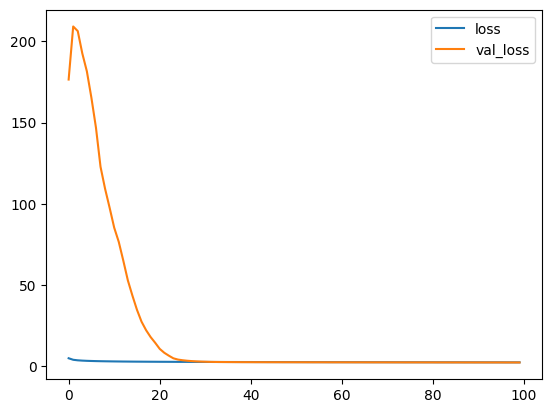

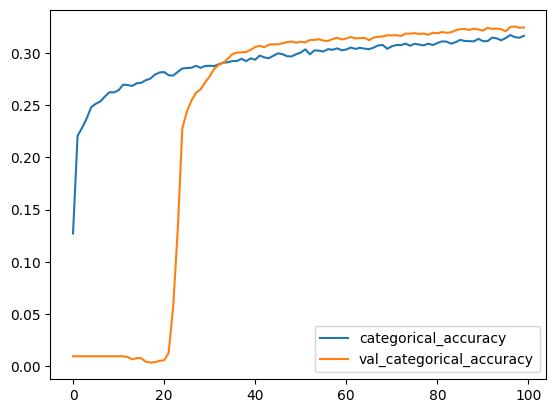

In [53]:
# Eximindo os graficos utilizando o proprio pandas
weather_df = pd.DataFrame(weather.history)
weather_df.loc[:, ['loss', 'val_loss']].plot()
weather_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(weather_df['val_loss'].min(), 
              weather_df['val_categorical_accuracy'].max()))

In [64]:
X_TESTE = teste.drop('Daily Summary', axis=1)
y_TESTE = teste['Daily Summary']

In [74]:
predictions = model.predict(X_TESTE)

603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [72]:
predictions

array([[4.12526475e-07, 1.44445585e-05, 1.05619365e-04, ...,
        1.84804151e-06, 2.83884174e-06, 3.27131747e-05],
       [2.15863997e-06, 9.11113247e-08, 6.02179568e-07, ...,
        4.01291300e-06, 2.93562994e-06, 1.16016918e-06],
       [6.15604733e-07, 1.07365611e-06, 3.28794840e-08, ...,
        3.98531438e-06, 8.44043086e-07, 4.23981902e-07],
       ...,
       [2.56497106e-06, 5.94086259e-07, 3.73616672e-06, ...,
        3.21563311e-06, 1.79271010e-05, 3.06566426e-06],
       [8.88980358e-05, 5.34783749e-06, 4.72342163e-06, ...,
        1.72648433e-05, 2.43896047e-05, 9.99364966e-06],
       [1.13339945e-06, 9.50058961e-07, 1.74861282e-06, ...,
        1.69884495e-03, 6.21570449e-04, 1.68285424e-05]], dtype=float32)

In [71]:
y_TESTE

34989    197.0
11453     35.0
3884      29.0
20780     57.0
22768    115.0
         ...  
73097     43.0
34703    154.0
12011    111.0
47785    111.0
78669    197.0
Name: Daily Summary, Length: 19290, dtype: float64